In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBRegressor
from tensorflow import keras
from scipy.interpolate import interpn
from tqdm import tqdm
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [2]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)
df = pd.get_dummies(df, columns=['steel_family'], prefix='steel').drop(['steel_grade'], axis=1)

Dropped 25 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [5]:
def scale_data(df, binary_prefix='steel_'):

    # Identify binary columns
    binary_columns = [col for col in df.columns if col.startswith(binary_prefix)]
    
    # Identify columns to scale (non-binary columns)
    columns_to_scale = [col for col in df.columns if col not in binary_columns + ['r_value']]
    
    # Scale numerical features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[columns_to_scale])
    
    # Create new dataframe with scaled data
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
    
    # Add back binary columns
    for col in binary_columns:
        scaled_df[col] = df[col].values
    
    # Add target variable if present
    if 'r_value' in df.columns:
        scaled_df['r_value'] = df['r_value'].values
    
    return scaled_df, scaler

def train_model_with_cv_gridsearch(df, model, param_grid=None, n_splits=5, random_state=42, use_grid_search=True, model_params=None):
    """
    Train a model with optional grid search and cross-validation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    model : estimator object
        Machine learning model to train
    param_grid : dict, optional
        Parameter grid for grid search (used if use_grid_search=True)
    n_splits : int, optional
        Number of cross-validation splits (default: 5)
    random_state : int, optional
        Random state for reproducibility (default: 42)
    use_grid_search : bool, optional
        Whether to perform grid search (default: True)
    model_params : dict, optional
        Direct model parameters to use if use_grid_search=False
    
    Returns:
    --------
    dict containing model results and performance metrics including tol90
    """
    # Prepare X and y
    X = df.drop(['r_value'], axis=1)
    y = df['r_value']
    
    # Initialize cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize metrics storage
    cv_scores = {
        'mae': [],
        'mse': [],
        'r2': [],
        'tol90': []  # Add tol90 metric
    }
    
    # Determine model parameters
    if use_grid_search:
        if param_grid is None:
            raise ValueError("param_grid must be provided when use_grid_search is True")
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=n_splits,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit GridSearchCV
        print("Performing GridSearch...")
        grid_search.fit(X, y)
        print(f"\nBest parameters: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
    else:
        # Use directly specified parameters or default model
        if model_params:
            best_model = type(model)(**model_params)
        else:
            best_model = model
        
        grid_search = None
    
    # Perform cross-validation
    print("\nPerforming cross-validation...")
    pbar = tqdm(enumerate(kf.split(X), 1),
                total=n_splits,
                desc="Cross-validation",
                leave=True)
    
    for fold, (train_idx, val_idx) in pbar:
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train model
        best_model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = best_model.predict(X_val)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        # Calculate tol90 (90th percentile of absolute errors)
        abs_errors = np.abs(y_val - y_pred)
        tol90 = np.percentile(abs_errors, 90)
        
        cv_scores['mae'].append(mae)
        cv_scores['mse'].append(mse)
        cv_scores['r2'].append(r2)
        cv_scores['tol90'].append(tol90)
        
        # Update progress bar description
        pbar.set_description(
            f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, TOL90: {tol90:.4f}"
        )
    
    # Prepare results
    results = {
        'model': best_model,
        'best_params': grid_search.best_params_ if use_grid_search else model_params or {},
        'avg_mae': np.mean(cv_scores['mae']),
        'std_mae': np.std(cv_scores['mae']),
        'avg_mse': np.mean(cv_scores['mse']),
        'std_mse': np.std(cv_scores['mse']),
        'avg_r2': np.mean(cv_scores['r2']),
        'std_r2': np.std(cv_scores['r2']),
        'avg_tol90': np.mean(cv_scores['tol90']),  # Add average tol90
        'std_tol90': np.std(cv_scores['tol90']),   # Add std of tol90
        'cv_scores': cv_scores,
        'grid_search_results': grid_search.cv_results_ if use_grid_search else None
    }
    
    return results

def report_cv_results(results):
    print("\nCross-Validation Results:")
    print("-" * 50)
    print(f"Best Parameters: {results['best_params']}")
    print(f"Average MAE: {results['avg_mae']:.4f} ± {results['std_mae']:.4f}")
    print(f"Average MSE: {results['avg_mse']:.4f} ± {results['std_mse']:.4f}")
    print(f"Average R2: {results['avg_r2']:.4f} ± {results['std_r2']:.4f}")
    print(f"Average TOL90: {results['avg_tol90']:.4f} ± {results['std_tol90']:.4f}")

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_scaled_df, scaler = scale_data(train_df)
binary_columns = [col for col in test_df.columns if col.startswith('steel_')]
columns_to_scale = [col for col in test_df.columns if col not in binary_columns + ['r_value']]
scaled_test_data = scaler.transform(test_df[columns_to_scale])
test_scaled_df = pd.DataFrame(scaled_test_data, columns=columns_to_scale)
for col in binary_columns:
    test_scaled_df[col] = test_df[col].values
if 'r_value' in test_df.columns:
    test_scaled_df['r_value'] = test_df['r_value'].values

In [14]:
rfr = RandomForestRegressor(random_state=42)
rfr_param_grid = {
    'n_estimators': range(100, 500, 50)
}

rfr_results = train_model_with_cv_gridsearch(
    df=train_scaled_df,
    model=rfr,
    param_grid=rfr_param_grid,
    n_splits=5
)

Performing GridSearch...

Best parameters: {'n_estimators': 450}

Performing cross-validation...


Fold 5 - MAE: 0.0858, MSE: 0.0144, R2: 0.9574, TOL90: 0.1998: 100%|██████████| 5/5 [05:48<00:00, 69.64s/it]


In [15]:
xgb_model = XGBRegressor(random_state=42)

xgb_param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'lambda': [0, 0.01, 0.1, 1, 10, 50],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

xgb_results = train_model_with_cv_gridsearch(
    df=train_scaled_df,
    model=xgb_model,
    param_grid=xgb_param_grid,
    n_splits=5
)

Performing GridSearch...

Best parameters: {'eta': 0.1, 'lambda': 0.1, 'max_depth': 8}

Performing cross-validation...


Fold 5 - MAE: 0.0873, MSE: 0.0146, R2: 0.9571, TOL90: 0.1984: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


In [19]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

results_without_grid = train_model_with_cv_gridsearch(
    df=train_scaled_df, 
    model=GaussianProcessRegressor(), 
    use_grid_search=False,
    model_params={'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)}
)


Performing cross-validation...


Fold 5 - MAE: 0.0940, MSE: 0.0163, R2: 0.9520, TOL90: 0.2071: 100%|██████████| 5/5 [56:41<00:00, 680.34s/it]


In [20]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

knn_param_grid = {
    'n_neighbors': list(range(2, 15)),
    'leaf_size': [20, 30, 40, 50],
    'weights': ['uniform', 'distance']
}

knn_results = train_model_with_cv_gridsearch(
    df=train_scaled_df,
    model=knn_model,
    param_grid=knn_param_grid
)

Performing GridSearch...

Best parameters: {'leaf_size': 20, 'n_neighbors': 10, 'weights': 'distance'}

Performing cross-validation...


Fold 5 - MAE: 0.1056, MSE: 0.0219, R2: 0.9356, TOL90: 0.2345: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


In [21]:
def cv_saved_model_architecture(saved_model_path, df, target_column='r_value', n_splits=5, 
                               epochs=100, batch_size=32, random_state=42):
    """
    Perform cross-validation using architecture and parameters from a saved model
    
    Parameters:
    -----------
    saved_model_path : str
        Path to saved .h5 model file
    df : pandas DataFrame
        Input data
    target_column : str
        Name of target column
    n_splits : int
        Number of CV folds
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict containing CV metrics
    """
    # Load saved model to get architecture and parameters
    base_model = tf.keras.models.load_model(saved_model_path)
    
            # Get learning rate from saved model and convert to Python float
    learning_rate = float(base_model.optimizer.learning_rate.numpy())
    
    # Prepare data
    X = df.drop([target_column], axis=1)
    y = df[target_column]
    
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Storage for CV metrics
    cv_scores = {
        'mae': [],
        'mse': [],
        'r2': []
    }
    
    # Perform cross-validation
    print("\nPerforming cross-validation...")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\nFold {fold}/{n_splits}")
        
        # Clear previous model from memory
        tf.keras.backend.clear_session()
        
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Convert to float32
        X_train = np.array(X_train, dtype=np.float32)
        y_train = np.array(y_train, dtype=np.float32)
        X_val = np.array(X_val, dtype=np.float32)
        y_val = np.array(y_val, dtype=np.float32)
        
        # Create new model with same architecture
        model = tf.keras.models.clone_model(base_model)
        
        # Compile with same optimizer type and learning rate
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=1e-4
        )
        
        # Create TF datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = (train_dataset
            .batch(batch_size, drop_remainder=True)
            .repeat())
        
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        val_dataset = val_dataset.batch(batch_size)
        
        steps_per_epoch = len(X_train) // batch_size
        
        # Train model
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Make predictions
        y_pred = model.predict(X_val, verbose=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        cv_scores['mae'].append(mae)
        cv_scores['mse'].append(mse)
        cv_scores['r2'].append(r2)
        
        print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")
    
    # Calculate average metrics
    results = {
        'avg_mae': np.mean(cv_scores['mae']),
        'std_mae': np.std(cv_scores['mae']),
        'avg_mse': np.mean(cv_scores['mse']),
        'std_mse': np.std(cv_scores['mse']),
        'avg_r2': np.mean(cv_scores['r2']),
        'std_r2': np.std(cv_scores['r2']),
        'cv_scores': cv_scores
    }
    
    return results

In [22]:
class SteelPropertiesANN:
    def __init__(self, input_dim, target_column):
        self.input_dim = input_dim
        self.target_column = target_column
        self.best_model = None
        self.best_params = None
        self.best_score = float('inf')

    def build_model(self, config):
        hidden_layers = config['layers']
        learning_rate = config['learning_rate']
        l2_strength = config['l2_regularization']
        
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(self.input_dim,)))
        
        for units, activation in hidden_layers:
            model.add(keras.layers.Dense(
                units=units,
                activation=activation,
                kernel_regularizer=keras.regularizers.l2(l2_strength)
            ))
        
        model.add(keras.layers.Dense(1))
        
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=100,
            decay_rate=0.9,
            staircase=True
        )
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0),
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        return model

    def generate_grid_configs(self, 
        layer_options=[(64, 'relu'), (128, 'relu'), (256, 'relu')],
        layer_depths=[2, 3, 4],
        learning_rates=[1e-2, 1e-3, 1e-4],
        l2_regularization=[1e-3, 1e-4, 1e-5],
        batch_sizes=[16, 32, 64]
    ):
        from itertools import product
        grid_configs = []
        
        for depth in layer_depths:
            for lr in learning_rates:
                for l2_reg in l2_regularization:
                    for batch_size in batch_sizes:
                        layer_combinations = list(product(layer_options, repeat=depth))
                        for layers in layer_combinations:
                            config = {
                                'layers': layers,
                                'learning_rate': lr,
                                'l2_regularization': l2_reg,
                                'batch_size': batch_size
                            }
                            grid_configs.append(config)
        
        return grid_configs

    def grid_search(self, train_scaled_df, grid_configs=None, epochs=100, max_configs=None):
        # Split training data into training and validation sets
        train_data, val_data = train_test_split(train_scaled_df, test_size=0.2, random_state=42)
    
        if grid_configs is None:
            grid_configs = self.generate_grid_configs()
        
        X_train = train_data.drop([self.target_column], axis=1)
        y_train = train_data[self.target_column]
        X_val = val_data.drop([self.target_column], axis=1)
        y_val = val_data[self.target_column]
        
        if max_configs:
            grid_configs = grid_configs[:max_configs]
        
        results = []
        for config in tqdm(grid_configs, desc="Training models"):
            tf.keras.backend.clear_session()
            model = self.build_model(config)
            batch_size = min(config['batch_size'], len(X_train))
            
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True,
                min_delta=1e-4
            )
            
            try:
                X_train = np.array(X_train, dtype=np.float32)
                y_train = np.array(y_train, dtype=np.float32)
                X_val = np.array(X_val, dtype=np.float32)
                y_val = np.array(y_val, dtype=np.float32)

                train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
                train_dataset = (train_dataset
                    .batch(batch_size, drop_remainder=True)
                    .repeat())
                
                val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
                val_dataset = val_dataset.batch(batch_size)
                
                steps_per_epoch = len(X_train) // batch_size
                
                history = model.fit(
                    train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[early_stopping],
                    verbose=0
                )
                
                val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                
                result_entry = config.copy()
                result_entry.update({'val_loss': val_loss})
                results.append(result_entry)
                
                if val_loss < self.best_score:
                    self.best_score = val_loss
                    self.best_model = model
                    self.best_params = config
                
            except Exception as e:
                print(f"Error with config {config}: {str(e)}")
                continue
        
        return self.best_model, self.best_params

In [23]:
cv_results = cv_saved_model_architecture(
    saved_model_path='model_mecomep2.h5',
    df=train_scaled_df,
    target_column='r_value',
    n_splits=5,
    epochs=100,
    batch_size=32
)

# Print CV results
print("\nCross-Validation Results:")
print("-" * 50)
print(f"Average MAE: {cv_results['avg_mae']:.4f} ± {cv_results['std_mae']:.4f}")
print(f"Average MSE: {cv_results['avg_mse']:.4f} ± {cv_results['std_mse']:.4f}")
print(f"Average R2: {cv_results['avg_r2']:.4f} ± {cv_results['std_r2']:.4f}")


Performing cross-validation...

Fold 1/5
Epoch 1/100
308/308 [==============================] - 1s 2ms/step - loss: 0.2094 - mae: 0.1861 - mse: 0.0806 - val_loss: 0.1512 - val_mae: 0.1287 - val_mse: 0.0297
Epoch 2/100
308/308 [==============================] - 0s 1ms/step - loss: 0.1485 - mae: 0.1267 - mse: 0.0283 - val_loss: 0.1401 - val_mae: 0.1189 - val_mse: 0.0249
Epoch 3/100
308/308 [==============================] - 0s 1ms/step - loss: 0.1385 - mae: 0.1180 - mse: 0.0251 - val_loss: 0.1375 - val_mae: 0.1175 - val_mse: 0.0243
Epoch 4/100
308/308 [==============================] - 0s 1ms/step - loss: 0.1352 - mae: 0.1159 - mse: 0.0243 - val_loss: 0.1362 - val_mae: 0.1174 - val_mse: 0.0233
Epoch 5/100
308/308 [==============================] - 0s 1ms/step - loss: 0.1283 - mae: 0.1100 - mse: 0.0222 - val_loss: 0.1369 - val_mae: 0.1190 - val_mse: 0.0246
Epoch 6/100
308/308 [==============================] - 0s 1ms/step - loss: 0.1261 - mae: 0.1088 - mse: 0.0218 - val_loss: 0.1541 - va

In [24]:
from sklearn.svm import SVR

svr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1, 2]
}

svr_results = train_model_with_cv_gridsearch(
    df=train_scaled_df,
    model=SVR(),
    param_grid=svr_param_grid
)

Performing GridSearch...

Best parameters: {'C': 1, 'epsilon': 0.01}

Performing cross-validation...


Fold 5 - MAE: 0.0956, MSE: 0.0176, R2: 0.9482, TOL90: 0.2191: 100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


In [13]:
from sklearn.linear_model import Ridge

ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

ridge_results = train_model_with_cv_gridsearch(
    df=train_scaled_df,
    model=Ridge(random_state=42),
    param_grid=ridge_param_grid
)

Performing GridSearch...

Best parameters: {'alpha': 0.1}

Performing cross-validation...


Fold 5 - MAE: 0.1208, MSE: 0.0250, R2: 0.9264, TOL90: 0.2566: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s]


In [11]:
def load_and_evaluate_model(data_df, features_dict, model_path, n_splits=5, batch_size=32):
    """
    Load saved model and perform cross validation
    
    Args:
        data_df: Pandas DataFrame containing the data
        features_dict: Dictionary of features by category
        model_path: Path to saved model file
        n_splits: Number of CV folds
        batch_size: Batch size for evaluation
    
    Returns:
        Dictionary of metrics averaged across folds, including tol90
    """
    # Load the saved model
    model = torch.load(model_path)
    model.eval()
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in data_df.columns]
        
        if available_features:
            feature_arrays[category] = data_df[available_features].values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(data_df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = data_df['r_value'].values
    
    # Initialize KFold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Lists to store metrics for each fold
    fold_metrics = {
        'mae': [],
        'mse': [],
        'rmse': [],
        'r2': [],
        'tol90': []  # Add tol90 to metrics
    }
    
    # Cross validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(targets)):
        # Prepare validation tensors for this fold
        val_tensors = {
            'chemical': torch.FloatTensor(feature_arrays['chemical'][val_idx]),
            'time': torch.FloatTensor(feature_arrays['time'][val_idx]),
            'process': torch.FloatTensor(feature_arrays['process'][val_idx]),
            'model': torch.FloatTensor(feature_arrays['model'][val_idx])
        }
        
        val_targets = torch.FloatTensor(targets[val_idx])
        
        # Create validation DataLoader
        val_dataset = TensorDataset(
            val_tensors['chemical'],
            val_tensors['time'],
            val_tensors['process'],
            val_tensors['model'],
            val_targets
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Evaluation for this fold
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in val_loader:
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                predictions.extend(outputs.numpy().flatten())
                actuals.extend(batch_targets.numpy().flatten())
        
        # Calculate metrics for this fold
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        
        mae = mean_absolute_error(actuals, predictions)
        mse = mean_squared_error(actuals, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(actuals, predictions)
        
        # Calculate tol90 (90th percentile of absolute errors)
        abs_errors = np.abs(actuals - predictions)
        tol90 = np.percentile(abs_errors, 90)
        
        fold_metrics['mae'].append(mae)
        fold_metrics['mse'].append(mse)
        fold_metrics['rmse'].append(rmse)
        fold_metrics['r2'].append(r2)
        fold_metrics['tol90'].append(tol90)
        
        print(f"Fold {fold+1} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, TOL90: {tol90:.4f}")
    
    # Calculate and return average metrics
    avg_metrics = {
        'mae': np.mean(fold_metrics['mae']),
        'mae_std': np.std(fold_metrics['mae']),
        'mse': np.mean(fold_metrics['mse']),
        'mse_std': np.std(fold_metrics['mse']), 
        'rmse': np.mean(fold_metrics['rmse']),
        'rmse_std': np.std(fold_metrics['rmse']),
        'r2': np.mean(fold_metrics['r2']),
        'r2_std': np.std(fold_metrics['r2']),
        'tol90': np.mean(fold_metrics['tol90']),  # Add average tol90
        'tol90_std': np.std(fold_metrics['tol90'])  # Add tol90 standard deviation
    }
    
    print("\nAverage Metrics across folds:")
    print(f"MAE: {avg_metrics['mae']:.4f} ± {avg_metrics['mae_std']:.4f}")
    print(f"MSE: {avg_metrics['mse']:.4f} ± {avg_metrics['mse_std']:.4f}")
    print(f"RMSE: {avg_metrics['rmse']:.4f} ± {avg_metrics['rmse_std']:.4f}")
    print(f"R2: {avg_metrics['r2']:.4f} ± {avg_metrics['r2_std']:.4f}")
    print(f"TOL90: {avg_metrics['tol90']:.4f} ± {avg_metrics['tol90_std']:.4f}")
    
    return avg_metrics

In [7]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family', 'steel_grade']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [19]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [20]:
def train_model_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    batch_size = hyperparameters['batch_size']
    
    # Initialize feature arrays and dimensions
    feature_arrays = {}
    feature_dims = {}
    
    # Process each feature category
    for category in ['chemical', 'time', 'process', 'model']:
        available_features = [col for col in features_dict[category] 
                            if col in df.columns]
        
        if available_features:
            feature_arrays[category] = df[available_features].values.astype(np.float32)
            feature_dims[category] = len(available_features)
        else:
            feature_arrays[category] = np.zeros((len(df), 0), dtype=np.float32)
            feature_dims[category] = 0
    
    # Prepare targets
    targets = df['r_value'].values
    
    # Split data
    split_data = train_test_split(
        feature_arrays['chemical'],
        feature_arrays['time'],
        feature_arrays['process'],
        feature_arrays['model'],
        targets,
        test_size=0.2,
        random_state=42
    )
    
    (X_train_chem, X_test_chem, X_train_time, X_test_time, 
     X_train_proc, X_test_proc, X_train_model, X_test_model, 
     y_train, y_test) = split_data
    
    # Convert to tensors
    train_tensors = {
        'chemical': torch.FloatTensor(X_train_chem),
        'time': torch.FloatTensor(X_train_time),
        'process': torch.FloatTensor(X_train_proc),
        'model': torch.FloatTensor(X_train_model)
    }
    
    test_tensors = {
        'chemical': torch.FloatTensor(X_test_chem),
        'time': torch.FloatTensor(X_test_time),
        'process': torch.FloatTensor(X_test_proc),
        'model': torch.FloatTensor(X_test_model)
    }
    
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create DataLoader
    train_dataset = TensorDataset(
        train_tensors['chemical'],
        train_tensors['time'],
        train_tensors['process'],
        train_tensors['model'],
        y_train_tensor
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Initialize model
    model = MultiBranchSteelRegressor(
        chemical_dim=feature_dims['chemical'],
        time_dim=feature_dims['time'],
        process_dim=feature_dims['process'],
        model_dim=feature_dims['model'],
        hidden_units=hyperparameters['hidden_units'],
        dropout_rate=hyperparameters['dropout_rate']
    )
    
    if use_l2:
        weight_decay = 0.001
    else:
        weight_decay = 0.0
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=weight_decay)
    criterion = nn.L1Loss()
    
    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_chem, batch_time, batch_proc, batch_model)
            loss = criterion(outputs, batch_targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(
            test_tensors['chemical'],
            test_tensors['time'],
            test_tensors['process'],
            test_tensors['model']
        )
        test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
        y_pred_np = y_pred.numpy().flatten()
        r2 = r2_score(y_test, y_pred_np)
        mae = mean_absolute_error(y_test, y_pred_np)
        mse = mean_squared_error(y_test, y_pred_np)
        
        metrics = {
            'r2_score': r2,
            'mae': mae,
            'mse': mse,
            'test_loss': test_loss
        }
        print(f"Evaluation - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")
    
    return model, metrics

In [24]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.01, 1e-3],
    'batch_size': [16, 32, 64],
    'hidden_units': [64, 128, 256],
    'dropout_rate': [0, 0.2]
}
grid = ParameterGrid(param_grid)

In [25]:
num_epochs = 50
best_params = None
best_results = {'mae': float('inf')}

for params in tqdm(grid, desc="Grid Search Progress", leave=True):
    print(f"Evaluating hyperparameters: {params}")
    
    model, metrics = train_model_regular(train_scaled_df, features_dict, num_epochs, params)
    mae = metrics['mae']
    
    if best_params is None or mae < best_results['mae']:
        best_results = {
            'mae': mae,
            'metrics': metrics
        }
        best_params = params

print(f"Best parameters found: {best_params}")
print(f"Best MAE: {best_results['mae']:.4f}")


Grid Search Progress:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1173
Epoch [20/50], Loss: 0.1091
Epoch [30/50], Loss: 0.1079
Epoch [40/50], Loss: 0.1044


Grid Search Progress:   3%|▎         | 1/36 [01:19<46:13, 79.25s/it]

Epoch [50/50], Loss: 0.1028
Evaluation - Test Loss: 0.1016, R2: 0.9398
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1184
Epoch [20/50], Loss: 0.1057
Epoch [30/50], Loss: 0.1002
Epoch [40/50], Loss: 0.0974


Grid Search Progress:   6%|▌         | 2/36 [02:41<45:51, 80.94s/it]

Epoch [50/50], Loss: 0.0944
Evaluation - Test Loss: 0.0917, R2: 0.9523
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1187
Epoch [20/50], Loss: 0.1096
Epoch [30/50], Loss: 0.1062
Epoch [40/50], Loss: 0.1032


Grid Search Progress:   8%|▊         | 3/36 [04:06<45:32, 82.82s/it]

Epoch [50/50], Loss: 0.1015
Evaluation - Test Loss: 0.1061, R2: 0.9364
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1163
Epoch [20/50], Loss: 0.1043
Epoch [30/50], Loss: 0.0989
Epoch [40/50], Loss: 0.0973


Grid Search Progress:  11%|█         | 4/36 [05:33<45:03, 84.47s/it]

Epoch [50/50], Loss: 0.0937
Evaluation - Test Loss: 0.0923, R2: 0.9513
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1208
Epoch [20/50], Loss: 0.1109
Epoch [30/50], Loss: 0.1050
Epoch [40/50], Loss: 0.1023


Grid Search Progress:  14%|█▍        | 5/36 [07:08<45:38, 88.32s/it]

Epoch [50/50], Loss: 0.1008
Evaluation - Test Loss: 0.0966, R2: 0.9452
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1172
Epoch [20/50], Loss: 0.1051
Epoch [30/50], Loss: 0.0981
Epoch [40/50], Loss: 0.0947


Grid Search Progress:  17%|█▋        | 6/36 [08:47<45:56, 91.90s/it]

Epoch [50/50], Loss: 0.0937
Evaluation - Test Loss: 0.0985, R2: 0.9424
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1560
Epoch [20/50], Loss: 0.1496
Epoch [30/50], Loss: 0.1501
Epoch [40/50], Loss: 0.1474


Grid Search Progress:  19%|█▉        | 7/36 [10:16<44:02, 91.12s/it]

Epoch [50/50], Loss: 0.1441
Evaluation - Test Loss: 0.1036, R2: 0.9435
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1533
Epoch [20/50], Loss: 0.1398
Epoch [30/50], Loss: 0.1367
Epoch [40/50], Loss: 0.1341


Grid Search Progress:  22%|██▏       | 8/36 [11:45<42:08, 90.32s/it]

Epoch [50/50], Loss: 0.1352
Evaluation - Test Loss: 0.1055, R2: 0.9412
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1574
Epoch [20/50], Loss: 0.1483
Epoch [30/50], Loss: 0.1475
Epoch [40/50], Loss: 0.1459


Grid Search Progress:  25%|██▌       | 9/36 [13:13<40:22, 89.72s/it]

Epoch [50/50], Loss: 0.1422
Evaluation - Test Loss: 0.1213, R2: 0.9181
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1549
Epoch [20/50], Loss: 0.1408
Epoch [30/50], Loss: 0.1338
Epoch [40/50], Loss: 0.1320


Grid Search Progress:  28%|██▊       | 10/36 [14:37<38:04, 87.87s/it]

Epoch [50/50], Loss: 0.1309
Evaluation - Test Loss: 0.1036, R2: 0.9421
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1498
Epoch [20/50], Loss: 0.1448
Epoch [30/50], Loss: 0.1420
Epoch [40/50], Loss: 0.1416


Grid Search Progress:  31%|███       | 11/36 [16:10<37:17, 89.51s/it]

Epoch [50/50], Loss: 0.1377
Evaluation - Test Loss: 0.0996, R2: 0.9459
Evaluating hyperparameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1516
Epoch [20/50], Loss: 0.1378
Epoch [30/50], Loss: 0.1310
Epoch [40/50], Loss: 0.1278


Grid Search Progress:  33%|███▎      | 12/36 [17:44<36:18, 90.77s/it]

Epoch [50/50], Loss: 0.1270
Evaluation - Test Loss: 0.0982, R2: 0.9456
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1124
Epoch [20/50], Loss: 0.1016
Epoch [30/50], Loss: 0.0993
Epoch [40/50], Loss: 0.0954


Grid Search Progress:  36%|███▌      | 13/36 [18:24<28:53, 75.35s/it]

Epoch [50/50], Loss: 0.0925
Evaluation - Test Loss: 0.0910, R2: 0.9518
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1087
Epoch [20/50], Loss: 0.1009
Epoch [30/50], Loss: 0.0971
Epoch [40/50], Loss: 0.0918


Grid Search Progress:  39%|███▉      | 14/36 [19:06<23:54, 65.21s/it]

Epoch [50/50], Loss: 0.0891
Evaluation - Test Loss: 0.0961, R2: 0.9455
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1104
Epoch [20/50], Loss: 0.1043
Epoch [30/50], Loss: 0.0983
Epoch [40/50], Loss: 0.0974


Grid Search Progress:  42%|████▏     | 15/36 [19:49<20:30, 58.58s/it]

Epoch [50/50], Loss: 0.0936
Evaluation - Test Loss: 0.0913, R2: 0.9501
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1094
Epoch [20/50], Loss: 0.1018
Epoch [30/50], Loss: 0.0957
Epoch [40/50], Loss: 0.0929


Grid Search Progress:  44%|████▍     | 16/36 [20:31<17:53, 53.69s/it]

Epoch [50/50], Loss: 0.0878
Evaluation - Test Loss: 0.0914, R2: 0.9523
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1100
Epoch [20/50], Loss: 0.1021
Epoch [30/50], Loss: 0.0970
Epoch [40/50], Loss: 0.0932


Grid Search Progress:  47%|████▋     | 17/36 [21:19<16:26, 51.93s/it]

Epoch [50/50], Loss: 0.0906
Evaluation - Test Loss: 0.0950, R2: 0.9480
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1058
Epoch [20/50], Loss: 0.0969
Epoch [30/50], Loss: 0.0926
Epoch [40/50], Loss: 0.0886


Grid Search Progress:  50%|█████     | 18/36 [22:05<15:04, 50.23s/it]

Epoch [50/50], Loss: 0.0869
Evaluation - Test Loss: 0.0943, R2: 0.9470
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1474
Epoch [20/50], Loss: 0.1399
Epoch [30/50], Loss: 0.1351
Epoch [40/50], Loss: 0.1334


Grid Search Progress:  53%|█████▎    | 19/36 [22:48<13:33, 47.84s/it]

Epoch [50/50], Loss: 0.1300
Evaluation - Test Loss: 0.1003, R2: 0.9438
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1638
Epoch [20/50], Loss: 0.1415
Epoch [30/50], Loss: 0.1316
Epoch [40/50], Loss: 0.1269


Grid Search Progress:  56%|█████▌    | 20/36 [23:30<12:20, 46.27s/it]

Epoch [50/50], Loss: 0.1253
Evaluation - Test Loss: 0.1031, R2: 0.9403
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1437
Epoch [20/50], Loss: 0.1344
Epoch [30/50], Loss: 0.1336
Epoch [40/50], Loss: 0.1274


Grid Search Progress:  58%|█████▊    | 21/36 [24:15<11:26, 45.75s/it]

Epoch [50/50], Loss: 0.1255
Evaluation - Test Loss: 0.1090, R2: 0.9341
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1514
Epoch [20/50], Loss: 0.1361
Epoch [30/50], Loss: 0.1281
Epoch [40/50], Loss: 0.1247


Grid Search Progress:  61%|██████    | 22/36 [24:59<10:35, 45.36s/it]

Epoch [50/50], Loss: 0.1214
Evaluation - Test Loss: 0.0955, R2: 0.9486
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1417
Epoch [20/50], Loss: 0.1354
Epoch [30/50], Loss: 0.1300
Epoch [40/50], Loss: 0.1288


Grid Search Progress:  64%|██████▍   | 23/36 [25:49<10:07, 46.74s/it]

Epoch [50/50], Loss: 0.1256
Evaluation - Test Loss: 0.1008, R2: 0.9419
Evaluating hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1498
Epoch [20/50], Loss: 0.1313
Epoch [30/50], Loss: 0.1246
Epoch [40/50], Loss: 0.1207


Grid Search Progress:  67%|██████▋   | 24/36 [26:39<09:33, 47.77s/it]

Epoch [50/50], Loss: 0.1190
Evaluation - Test Loss: 0.0957, R2: 0.9489
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1092
Epoch [20/50], Loss: 0.1000
Epoch [30/50], Loss: 0.0941
Epoch [40/50], Loss: 0.0924


Grid Search Progress:  69%|██████▉   | 25/36 [27:01<07:20, 40.07s/it]

Epoch [50/50], Loss: 0.0888
Evaluation - Test Loss: 0.0978, R2: 0.9421
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1047
Epoch [20/50], Loss: 0.0960
Epoch [30/50], Loss: 0.0901
Epoch [40/50], Loss: 0.0889


Grid Search Progress:  72%|███████▏  | 26/36 [27:24<05:49, 34.91s/it]

Epoch [50/50], Loss: 0.0847
Evaluation - Test Loss: 0.0984, R2: 0.9443
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1086
Epoch [20/50], Loss: 0.0964
Epoch [30/50], Loss: 0.0940
Epoch [40/50], Loss: 0.0899


Grid Search Progress:  75%|███████▌  | 27/36 [27:48<04:43, 31.55s/it]

Epoch [50/50], Loss: 0.0878
Evaluation - Test Loss: 0.0904, R2: 0.9505
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1028
Epoch [20/50], Loss: 0.0948
Epoch [30/50], Loss: 0.0903
Epoch [40/50], Loss: 0.0852


Grid Search Progress:  78%|███████▊  | 28/36 [28:12<03:53, 29.23s/it]

Epoch [50/50], Loss: 0.0820
Evaluation - Test Loss: 0.0938, R2: 0.9500
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1104
Epoch [20/50], Loss: 0.0974
Epoch [30/50], Loss: 0.0900
Epoch [40/50], Loss: 0.0879


Grid Search Progress:  81%|████████  | 29/36 [28:39<03:19, 28.52s/it]

Epoch [50/50], Loss: 0.0853
Evaluation - Test Loss: 0.0902, R2: 0.9525
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.0997
Epoch [20/50], Loss: 0.0921
Epoch [30/50], Loss: 0.0916
Epoch [40/50], Loss: 0.0839


Grid Search Progress:  83%|████████▎ | 30/36 [29:05<02:46, 27.72s/it]

Epoch [50/50], Loss: 0.0811
Evaluation - Test Loss: 0.0912, R2: 0.9511
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1374
Epoch [20/50], Loss: 0.1276
Epoch [30/50], Loss: 0.1258
Epoch [40/50], Loss: 0.1255


Grid Search Progress:  86%|████████▌ | 31/36 [29:29<02:13, 26.64s/it]

Epoch [50/50], Loss: 0.1196
Evaluation - Test Loss: 0.0966, R2: 0.9482
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 64, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1627
Epoch [20/50], Loss: 0.1424
Epoch [30/50], Loss: 0.1320
Epoch [40/50], Loss: 0.1229


Grid Search Progress:  89%|████████▉ | 32/36 [29:52<01:42, 25.70s/it]

Epoch [50/50], Loss: 0.1200
Evaluation - Test Loss: 0.0948, R2: 0.9491
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1325
Epoch [20/50], Loss: 0.1255
Epoch [30/50], Loss: 0.1227
Epoch [40/50], Loss: 0.1230


Grid Search Progress:  92%|█████████▏| 33/36 [30:18<01:16, 25.59s/it]

Epoch [50/50], Loss: 0.1170
Evaluation - Test Loss: 0.0949, R2: 0.9486
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 128, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1555
Epoch [20/50], Loss: 0.1355
Epoch [30/50], Loss: 0.1243
Epoch [40/50], Loss: 0.1194


Grid Search Progress:  94%|█████████▍| 34/36 [30:43<00:51, 25.67s/it]

Epoch [50/50], Loss: 0.1166
Evaluation - Test Loss: 0.0953, R2: 0.9483
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.01}
Epoch [10/50], Loss: 0.1293
Epoch [20/50], Loss: 0.1269
Epoch [30/50], Loss: 0.1252
Epoch [40/50], Loss: 0.1202


Grid Search Progress:  97%|█████████▋| 35/36 [31:11<00:26, 26.38s/it]

Epoch [50/50], Loss: 0.1153
Evaluation - Test Loss: 0.1040, R2: 0.9374
Evaluating hyperparameters: {'batch_size': 64, 'dropout_rate': 0.2, 'hidden_units': 256, 'learning_rate': 0.001}
Epoch [10/50], Loss: 0.1526
Epoch [20/50], Loss: 0.1352
Epoch [30/50], Loss: 0.1226
Epoch [40/50], Loss: 0.1176


Grid Search Progress: 100%|██████████| 36/36 [31:40<00:00, 52.78s/it]

Epoch [50/50], Loss: 0.1168
Evaluation - Test Loss: 0.0967, R2: 0.9479
Best parameters found: {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.01}
Best MAE: 0.0902


In [26]:
best_params_bmlp = {'batch_size': 64, 'dropout_rate': 0, 'hidden_units': 256, 'learning_rate': 0.01}
best_mlp = train_model_regular(train_scaled_df, features_dict, 100, best_params_bmlp)
torch.save(best_mlp[0], 'branchmlp_mecomep.pth')

# Perform cross validation
metrics = load_and_evaluate_model(
    data_df=train_scaled_df,
    features_dict=features_dict,
    model_path='branchmlp_mecomep.pth',
    n_splits=5,
    batch_size=32
)

Epoch [10/100], Loss: 0.1065
Epoch [20/100], Loss: 0.0988
Epoch [30/100], Loss: 0.0927
Epoch [40/100], Loss: 0.0885
Epoch [50/100], Loss: 0.0841
Epoch [60/100], Loss: 0.0849
Epoch [70/100], Loss: 0.0799
Epoch [80/100], Loss: 0.0771
Epoch [90/100], Loss: 0.0764
Epoch [100/100], Loss: 0.0766
Evaluation - Test Loss: 0.0913, R2: 0.9487
Fold 1 - MAE: 0.0913, MSE: 0.0170, RMSE: 0.1304, R2: 0.9487, TOL90: 0.2094
Fold 2 - MAE: 0.0637, MSE: 0.0084, RMSE: 0.0919, R2: 0.9750, TOL90: 0.1527
Fold 3 - MAE: 0.0667, MSE: 0.0096, RMSE: 0.0980, R2: 0.9716, TOL90: 0.1582
Fold 4 - MAE: 0.0699, MSE: 0.0101, RMSE: 0.1004, R2: 0.9702, TOL90: 0.1638
Fold 5 - MAE: 0.0657, MSE: 0.0091, RMSE: 0.0955, R2: 0.9731, TOL90: 0.1576

Average Metrics across folds:
MAE: 0.0715 ± 0.0101
MSE: 0.0109 ± 0.0031
RMSE: 0.1032 ± 0.0139
R2: 0.9677 ± 0.0096
TOL90: 0.1683 ± 0.0208


In [27]:
def tol90(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.percentile(errors, 90)

def density_scatter(x, y, bins=30, **kwargs):
    """Create a density scatter plot"""
    # Ensure inputs are 1D arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:] + y_e[:-1])),
                data.T/data.max(),
                np.vstack([x,y]).T,
                method="splinef2d",
                bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x, y, c=z, **kwargs)

def plot_predicted_vs_actual(model, df, features_dict=None, model_type=None, target_column='r_value', title=None, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    # Get actual values
    actual = df[target_column].values
    
    # Get predictions based on model type
    if model_type == 'pytorch_mlp':
        # Prepare feature arrays for PyTorch MLP
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category] 
                                if col in df.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(df[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(df), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        model.eval()
        with torch.no_grad():
            predicted = model(**input_tensors).numpy().flatten()
            
    elif model_type == 'keras':
        X = df.drop([target_column], axis=1).values
        X = X.astype('float32')
        predicted = model.predict(X).flatten()
        
    else:  # sklearn
        X = df.drop([target_column], axis=1)
        predicted = model['model'].predict(X)
    
    # Calculate metrics
    r2 = r2_score(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    tol90_value = tol90(actual, predicted)
    
    # Create density scatter plot
    density_scatter(actual, predicted, bins=30, alpha=0.6)
    
    # Plot perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Plot tolerance lines
    plt.plot([min_val, max_val], [min_val + tol90_value, max_val + tol90_value],
             'g--', lw=1.5, label=f'+tol90 ({tol90_value:.4f})')
    plt.plot([min_val, max_val], [min_val - tol90_value, max_val - tol90_value],
             'b--', lw=1.5, label=f'-tol90 ({tol90_value:.4f})')
    
    # Set plot limits with buffer
    buffer = 0.2
    x_min = actual.min() - (actual.max() - actual.min()) * buffer
    x_max = actual.max() + (actual.max() - actual.min()) * buffer
    y_min = predicted.min() - (predicted.max() - predicted.min()) * buffer
    y_max = predicted.max() + (predicted.max() - predicted.min()) * buffer
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Annotate with metrics
    plt.text(0.05, 0.95,
             f"R²: {r2:.4f}\n" +
             f"MSE: {mse:.4f}\n" +
             f"MAE: {mae:.4f}\n" +
             f"tol90: {tol90_value:.4f}",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Labeling
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    if title is None:
        title = f'Predicted vs Actual {target_column}'
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    return {
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'tol90': tol90_value
    }

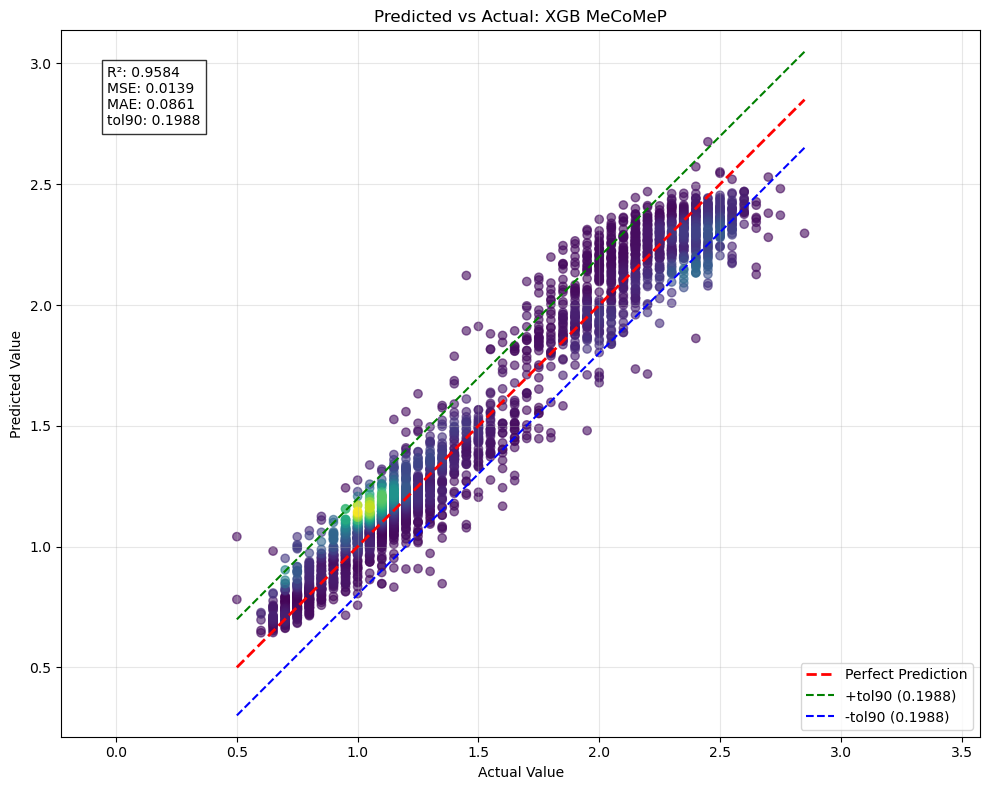

{'R2': 0.9584220037514284,
 'MSE': 0.01394087272986652,
 'MAE': 0.08614986331323068,
 'tol90': 0.1987912559509277}

In [49]:
plot_predicted_vs_actual(xgb_results, test_scaled_df, title='Predicted vs Actual: XGB MeCoMeP')

In [68]:
mecomep_data = {
    'R2': [0.9574, 0.9571, 0.9480, 0.9520, 0.9356, 0.9482, 0.9264, 0.9677],
    'MAE': [0.0858, 0.0873, 0.0956, 0.0940, 0.1056, 0.0956, 0.1208, 0.0715],
    'MSE': [0.0144, 0.0146, 0.0175, 0.0163, 0.0219, 0.0176, 0.0250, 0.0109],
    'TOL90': [0.1998, 0.1984, 1.3360, 0.2071, 0.2345, 0.2191, 0.2566, 0.1683]
}
models = ['RFR', 'XGB', 'ANN', 'GPR', 'KNN', 'SVR', 'Ridge', 'Branch MLP']

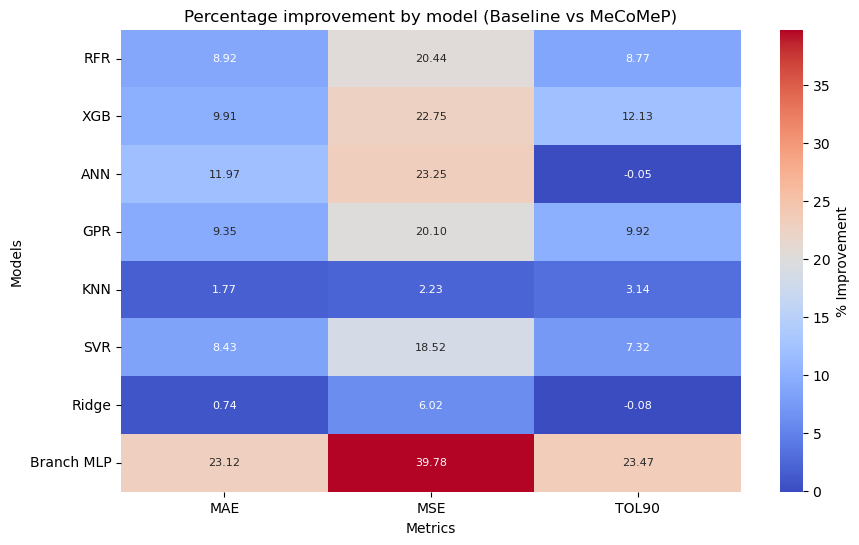

In [3]:
import seaborn as sns

# Baseline data
baseline_data = {
    'R2': [0.9467, 0.9443, 0.9324, 0.9399, 0.9338, 0.9362, 0.9216, 0.9461],
    'MAE': [0.0942, 0.0969, 0.1086, 0.1037, 0.1075, 0.1044, 0.1217, 0.0930],
    'MSE': [0.0181, 0.0189, 0.0228, 0.0204, 0.0224, 0.0216, 0.0266, 0.0181],
    'TOL90': [0.2190, 0.2258, 1.3353, 0.2299, 0.2421, 0.2364, 0.2564, 0.2199]
}

# MeCoMeP data
mecomep_data = {
    'R2': [0.9574, 0.9571, 0.9480, 0.9520, 0.9356, 0.9482, 0.9264, 0.9677],
    'MAE': [0.0858, 0.0873, 0.0956, 0.0940, 0.1056, 0.0956, 0.1208, 0.0715],
    'MSE': [0.0144, 0.0146, 0.0175, 0.0163, 0.0219, 0.0176, 0.0250, 0.0109],
    'TOL90': [0.1998, 0.1984, 1.3360, 0.2071, 0.2345, 0.2191, 0.2566, 0.1683]
}

improvements = {}
for metric in ['MAE', 'MSE', 'TOL90']:  # Exclude R2
    baseline = np.array(baseline_data[metric])
    mecomep = np.array(mecomep_data[metric])
    improvement = ((baseline - mecomep) / baseline) * 100
    improvements[metric] = improvement

# Convert to a DataFrame
improvement_df = pd.DataFrame(improvements)

# Assign model names as row labels
models = ['RFR', 'XGB', 'ANN', 'GPR', 'KNN', 'SVR', 'Ridge', 'Branch MLP']
improvement_df.index = models

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(improvement_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': '% Improvement'}, annot_kws={"size": 8})
plt.title("Percentage improvement by model (Baseline vs MeCoMeP)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.show()
